<center> <h1>Αναγνώριση Προτύπων - Προπαρασκευή 3ης Εργαστηριακής Άσκησης</h1> </center>

---

<center> <h2>Θέμα: Αναγνώριση Είδους και Εξαγωγή Συναισθήματος από Μουσική</h2> </center>
<center> <h2>ΣΧΟΛΗ: ΣΗΜΜΥ</h2> </center>

Ονοματεπώνυμο | Αριθμός Μητρώου
------------ | -------------
Γιάννης Πιτόσκας | 03115077
Αντώνης Παπαοικονόμου | 03115140

# Βήμα 0

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

data_path = "../input/patreco3-multitask-affective-music/data/"
print(os.listdir(data_path))

['multitask_dataset_beat', 'multitask_dataset', 'fma_genre_spectrograms_beat', 'fma_genre_spectrograms']


# Βήμα 1

Με βάση τον κώδικα που έχουμε από το [Data Loading Tutorial](https://www.kaggle.com/geoparslp/data-loading-tutorial/data):

In [4]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}

# TODO: Comment on howv the train and validation splits are created.
# TODO: It's useful to set the seed when debugging but when experimenting ALWAYS set seed=None. Why?
def torch_train_val_split(
        dataset, batch_train, batch_eval,
        val_size=.2, shuffle=True, seed=None):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    return train_loader, val_loader


def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram


def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram

    
def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


# TODO: Comment on why padding is needed
class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

        
class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_fused_spectrogram):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, self.gold_labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(self.gold_labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(self.gold_labels)).astype('int64')

    def get_files_labels(self, txt, class_mapping):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], self.gold_labels[item], l

    def __len__(self):
        return len(self.labels)

Διαβάζοντας τα αρχεία από το path `/fma_genre_spectrograms/` εχουμε:

In [5]:
fma_genre_spectr_path = data_path + "fma_genre_spectrograms/"
# print(os.listdir(fma_genre_spectr_path)) 
    
train_specs_mel = SpectrogramDataset(
     fma_genre_spectr_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)

print("Train Loaded Successfuly.", "Train data length:", len(train_specs_mel))

 test_specs_mel = SpectrogramDataset(
     fma_genre_spectr_path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)
    
print("Test Loaded Successfuly.", "Test data length:", len(test_loader))

Train Loaded Successfuly. Train data length: 2305


In [16]:
import random

sr = 22050

rand_index_1 = random.randint(0, len(train_specs_mel)-1)
rand_index_2 = random.randint(0, len(train_specs_mel)-1)
rand_sample_1 = train_specs_mel[rand_index_1]
rand_sample_2 = train_specs_mel[rand_index_2]
while rand_sample_2[1] == rand_sample_1[1]:
    rand_index_2 = random.randint(0, len(train_specs_mel)-1)
    rand_sample_2 = train_specs_mel[rand_index_2]

# print(specs_fused.label_transformer.inverse_transform([rand_sample_1[1]]))
# print(rand_sample_1[2])
# print(rand_sample_2[2])

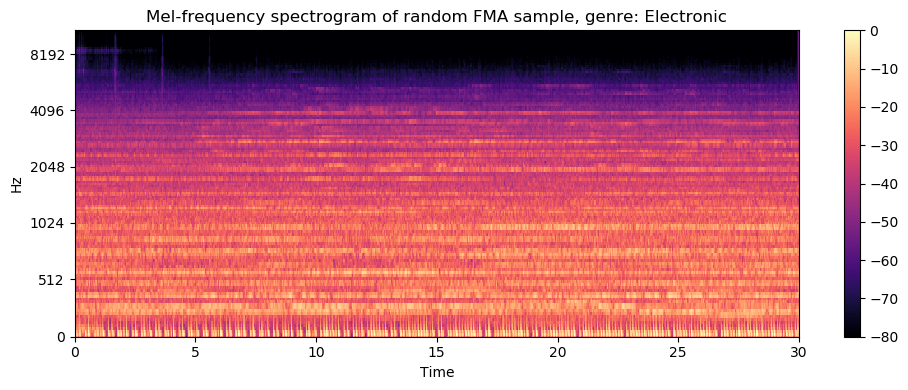

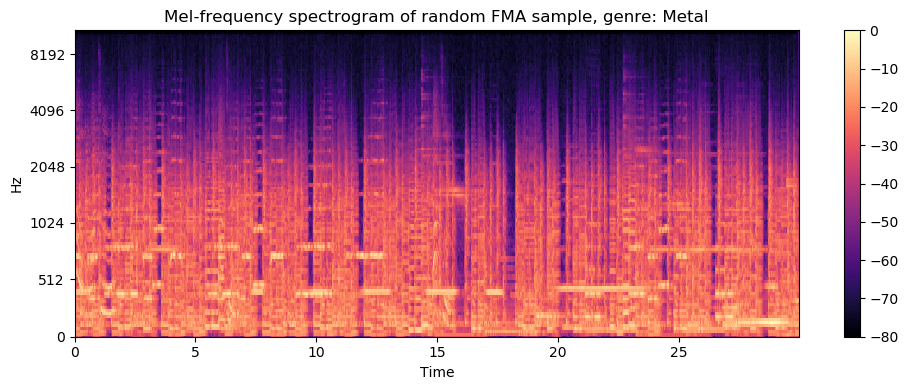

In [17]:
import IPython.display
import librosa.display
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_1[0], ref=np.max)
librosa.display.specshow(rand_sample_1[0], sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel-frequency spectrogram of random FMA sample, genre: '+rand_sample_1[2])
plt.tight_layout()
plt.show()

# rand_sample_1_audio = librosa.feature.inverse.mel_to_audio(rand_sample_1[0])
# IPython.display.Audio(rand_sample_1_audio, rate=sr)

plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_2[0], ref=np.max)
librosa.display.specshow(rand_sample_2[0], sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel-frequency spectrogram of random FMA sample, genre: '+rand_sample_2[2])
plt.tight_layout()
plt.show()

# rand_sample_2_audio = librosa.feature.inverse.mel_to_audio(rand_sample_2[0])
# IPython.display.Audio(rand_sample_2_audio, rate=sr)

>Παρατηρούμε

# Βήμα 2

(α)

In [18]:
print(rand_sample_1[0].shape)
print(rand_sample_2[0].shape)

(128, 1292)
(128, 1291)


(β)

In [19]:
fma_genre_spectr_beat_path = data_path + "fma_genre_spectrograms_beat/"
    
train_specs_beat_mel = SpectrogramDataset(
     fma_genre_spectr_beat_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)

print("Train Loaded Successfuly.", "Train data length:", len(train_specs_beat_mel))

Train Loaded Successfuly. Train data length: 2305


In [20]:
rand_sample_1 = train_specs_beat_mel[rand_index_1]
rand_sample_2 = train_specs_beat_mel[rand_index_2]

print(rand_sample_1[0].shape)
print(rand_sample_2[0].shape)

(128, 63)
(128, 56)


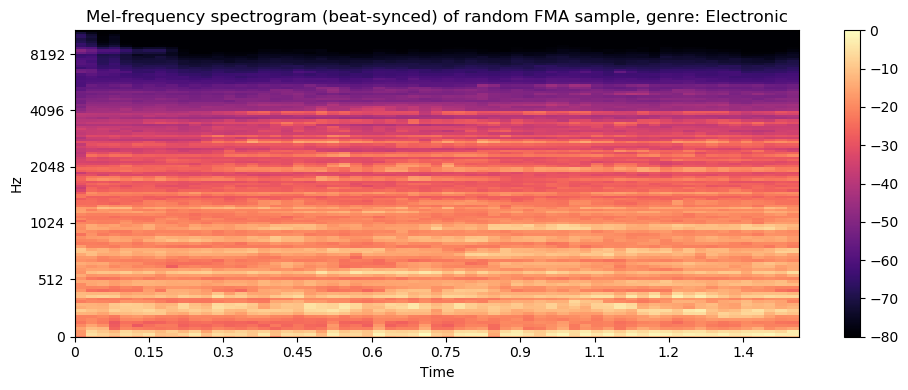

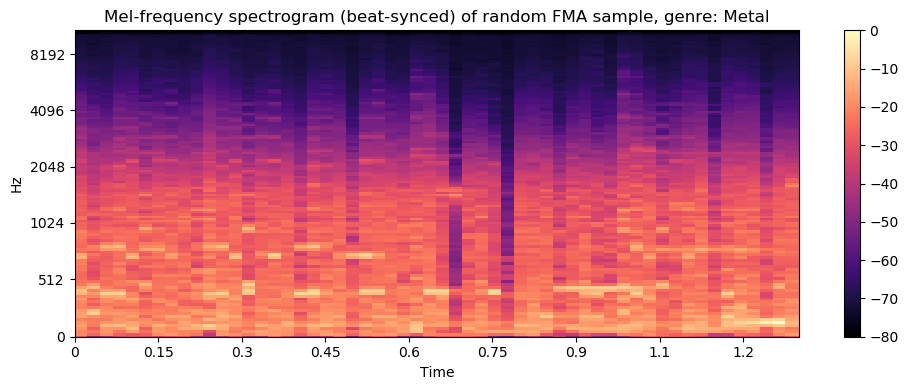

In [21]:
import IPython.display
import librosa.display
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

sr = 22050

plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_1[0], ref=np.max)
librosa.display.specshow(rand_sample_1[0], sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel-frequency spectrogram (beat-synced) of random FMA sample, genre: '+rand_sample_1[2])
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_2[0], ref=np.max)
librosa.display.specshow(rand_sample_2[0], sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel-frequency spectrogram (beat-synced) of random FMA sample, genre: '+rand_sample_2[2])
plt.tight_layout()
plt.show()

# Βήμα 3

In [22]:
chromas_train = SpectrogramDataset(
     fma_genre_spectr_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_chromagram)
    
rand_sample_1 = chromas_train[rand_index_1]
rand_sample_2 = chromas_train[rand_index_2]

print(rand_sample_1[0].shape)
print(rand_sample_2[0].shape)

(12, 1292)
(12, 1291)


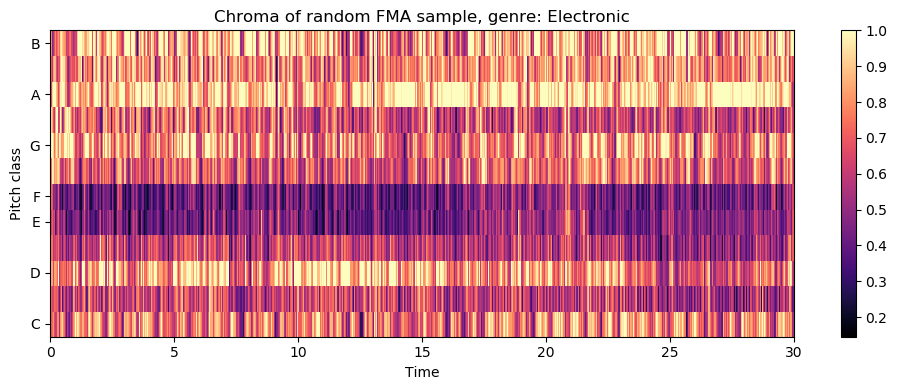

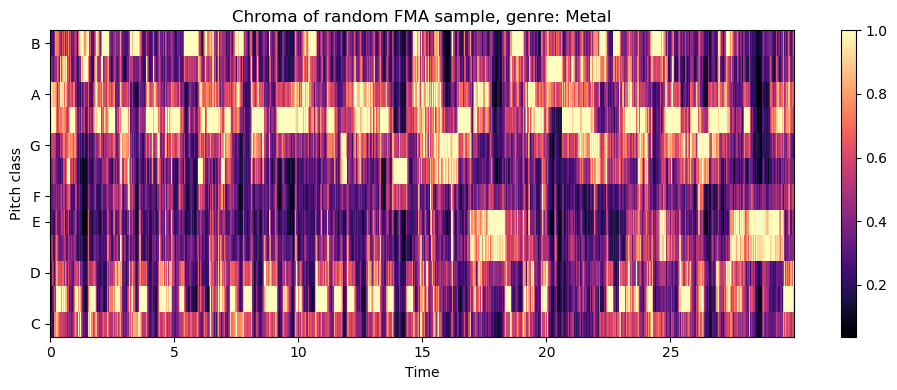

In [23]:
import IPython.display
import librosa.display
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

sr = 22050

plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_1[0], ref=np.max)
librosa.display.specshow(rand_sample_1[0], sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma of random FMA sample, genre: '+rand_sample_1[2])
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_2[0], ref=np.max)
librosa.display.specshow(rand_sample_2[0], sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma of random FMA sample, genre: '+rand_sample_2[2])
plt.tight_layout()
plt.show()

In [24]:
import random

chromas_beat_train = SpectrogramDataset(
     fma_genre_spectr_beat_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_chromagram)
    
rand_sample_1 = chromas_beat_train[rand_index_1]
rand_sample_2 = chromas_beat_train[rand_index_2]

print(rand_sample_1[0].shape)
print(rand_sample_2[0].shape)

(12, 63)
(12, 56)


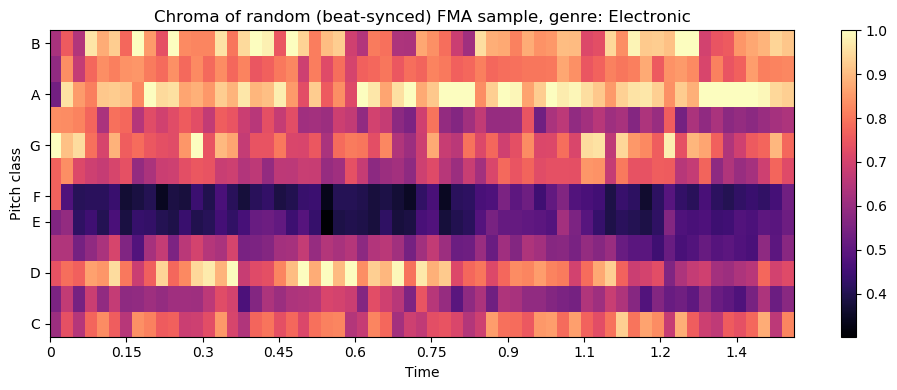

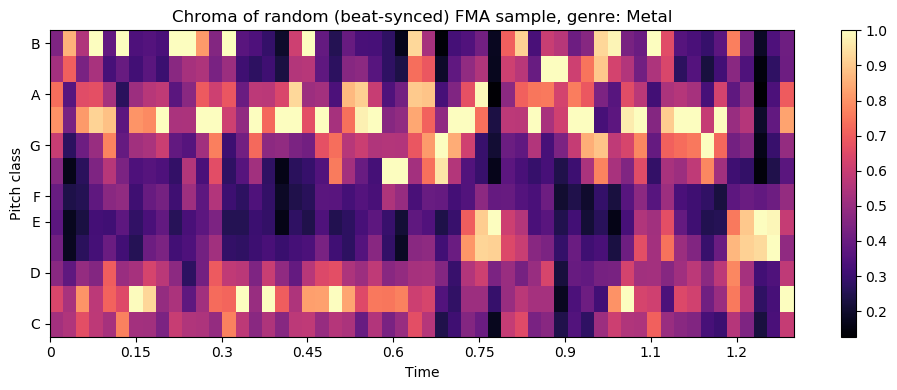

In [25]:
import IPython.display
import librosa.display
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

sr = 22050

plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_1[0], ref=np.max)
librosa.display.specshow(rand_sample_1[0], sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma of random (beat-synced) FMA sample, genre: '+rand_sample_1[2])
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(rand_sample_2[0], ref=np.max)
librosa.display.specshow(rand_sample_2[0], sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma of random (beat-synced) FMA sample, genre: '+rand_sample_2[2])
plt.tight_layout()
plt.show()

# Βήμα 4

In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
specs_without_mapping = SpectrogramDataset(
     fma_genre_spectr_path,
     train=True,
     class_mapping={},
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)

specs_with_mapping = SpectrogramDataset(
     fma_genre_spectr_path,
     train=True,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)

In [ ]:
import pandas as pd

df = pd.DataFrame(specs_without_mapping.feats)
for specs_without_mapping[:][0]

In [ ]:
plotPerColumnDistribution(df, 1, 1)

# Βήμα 5

Παρακάτω έχουμε μια υλοποίηση για ένα `LSTM` δίκτυο:

In [ ]:
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.0, 
                 num_layers=1, bidirectional=False, isPackedSequence=False):
        super(BasicLSTM, self).__init__()
        
        self.dropout_prob = dropout_prob
        self.bidirectional = bidirectional
        self.feature_size = hidden_dim * 2 if self.bidirectional else hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.isPackedSequence = isPackedSequence
        
        # Initialize the LSTM, Dropout, Output layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                                dropout=dropout_prob, batch_first=True, bidirectional= bidirectional)
        
        self.drop = nn.Dropout(p=dropout_prob)
        
        self.fc = nn.Linear(self.feature_size, self.output_dim)
        

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        N, L, D = x.size()
        
        if self.isPackedSequence:
            x = pack_padded_sequence(x, lengths, batch_first=True)
        
        out, _ = self.lstm(x)
        
        if self.isPackedSequence:
            out, _ = pad_packed_sequence(out, batch_first=True)
        
        dropped = self.drop(out)
        
        last = self.last_timestep(dropped, lengths)
        
        last_outputs = self.fc(last)
        
        # You must have all of the outputs of the LSTM
        # but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
              
        return last_outputs
    
    

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)
        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}\n\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...\n\n')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [ ]:
import math
import sys

def progress(loss, epoch, batch, batch_size, dataset_size):
    """
    Print the progress of the training for each epoch
    """
    batches = math.ceil(float(dataset_size) / batch_size)
    count = batch * batch_size
    bar_len = 40
    filled_len = int(round(bar_len * count / float(dataset_size)))

    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    status = 'Epoch {}, Loss: {:.4f}'.format(epoch, loss)
    _progress_str = "\r \r [{}] ...{}".format(bar, status)
    sys.stdout.write(_progress_str)
    sys.stdout.flush()

    if batch == batches:
        print()

In [ ]:
import torch
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

def train_dataset(_epoch, dataloader, model, loss_function, optimizer):
    
    model.train()
    running_loss = 0.0

    # obtain the model's device ID
    device = next(model.parameters()).device

    for index, batch in enumerate(dataloader, 1):

        # get the inputs (batch)
        inputs, labels, lengths = batch
        
        # Step 1 - move the batch tensors to the right device and also sort by length for packed sequence
        
        if model.isPackedSequence:
            sorted_by_len = sorted(zip(lengths, labels, inputs), key=lambda pair: pair[0], reverse=True) 
            lengths = Variable(torch.tensor([x for x, _, _ in sorted_by_len])).to(device)
            labels = Variable(torch.tensor([x for _, x, _ in sorted_by_len])).to(device)
            inputs = Variable(torch.cat([x.view(1, x.size(0), -1) for _, _, x in sorted_by_len])).to(device)
        else:            
            inputs = Variable(inputs).to(device)
            labels = Variable(labels).to(device)
            lengths = Variable(lengths).to(device)

        optimizer.zero_grad()

        # Step 2 - forward pass: y' = model(x)
        outputs = model(inputs, lengths)

        # Step 3 - compute loss: L = loss_function(y, y')
        loss = loss_function(outputs, labels)

        # Step 4 - backward pass: compute gradient wrt model parameters
        loss.backward()

        # Step 5 - update weights
        optimizer.step()

        running_loss += loss.data.item()

        # print statistics
        progress(loss=loss.data.item(),
                 epoch=_epoch,
                 batch=index,
                 batch_size=dataloader.batch_size,
                 dataset_size=len(dataloader.dataset))

    return running_loss / index


def eval_dataset(dataloader, model, loss_function):
    
    # IMPORTANT: switch to eval mode
    # disable regularization layers, such as Dropout
    model.eval()
    running_loss = 0.0

    y_pred = []  # the predicted labels
    y = []  # the gold labels

    # obtain the model's device ID
    device = next(model.parameters()).device

    # IMPORTANT: in evaluation mode, we don't want to keep the gradients
    # so we do everything under torch.no_grad()
    with torch.no_grad():
        for index, batch in enumerate(dataloader, 1):

            # get the inputs (batch)
            inputs, labels, lengths = batch

            # Step 1 - move the batch tensors to the right device and also sort by length for packed sequence
            
            if model.isPackedSequence:
                sorted_by_len = sorted(zip(lengths, labels, inputs), key=lambda pair: pair[0], reverse=True) 
                lengths = Variable(torch.tensor([x for x, _, _ in sorted_by_len])).to(device)
                labels = Variable(torch.tensor([x for _, x, _ in sorted_by_len])).to(device)
                inputs = Variable(torch.cat([x.view(1, x.size(0), -1) for _, _, x in sorted_by_len])).to(device)
            else:            
                inputs = Variable(inputs).to(device)
                labels = Variable(labels).to(device)
                lengths = Variable(lengths).to(device)
                    
            # Step 2 - forward pass: y' = model(x)
            outputs = model(inputs, lengths)

            # Step 3 - compute loss.
            # We compute the loss only for inspection (compare train/test loss)
            # because we do not actually backpropagate in test time
            loss = loss_function(outputs, labels)

            # Step 4 - make predictions (class = argmax of posteriors)
            _, posibol = torch.max(outputs.data, 1)

            # Step 5 - collect the predictions, gold labels and batch loss
            y_pred.extend(list(posibol.data.cpu().numpy().squeeze()))
            y.extend(list(labels.data.cpu().numpy().squeeze()))


            running_loss += loss.data.item()

    return running_loss / index, (y_pred, y)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import time

def train_and_val_model(EPOCHS, train_loader, val_loader, model, loss_function, optimizer, early_stopping_limit=0):

    total_train_loss = []
    total_val_loss = []
    
    if early_stopping_limit:
        early_stopping = EarlyStopping(patience=early_stopping_limit, verbose=True)
    
    start_time = time.time()
    
    for epoch in range(1, EPOCHS + 1):
        # train the model for one epoch
        train_dataset(epoch, train_loader, model, loss_function, optimizer)

        # evaluate the performance of the model
        train_loss, (y_train_pred, y_train_gold) = eval_dataset(train_loader, model, loss_function)
        print("Train Set: loss={:.4f}".format(train_loss))

        val_loss, (y_val_pred, y_val_gold) = eval_dataset(val_loader, model, loss_function)
        print("Validation Set: loss={:.4f}, accuracy={:.4f}\n".format(val_loss, 
                                                                      accuracy_score(y_val_gold, y_val_pred)))


        total_train_loss.append(train_loss)
        total_val_loss.append(val_loss)
        
        if early_stopping_limit:
            early_stopping(val_loss, model)
        
            if early_stopping.early_stop:
                print("Early stopping...")
                break

    if early_stopping_limit:        
        # load the last checkpoint with the best model
        model.load_state_dict(torch.load('checkpoint.pt'))
        
    print("\nTotal train and validation time: {:.2f} seconds".format((time.time() - start_time)))
    
    return total_train_loss, total_val_loss


def test_model(test_loader, model, loss_function, set):
    
    test_loss, (y_test_pred, y_test_gold) = eval_dataset(test_loader, model, loss_function)
    print("\n"+set+" Set: loss={:.4f}, accuracy={:.4f}, f1-macro={:.4f}".format(test_loss,
                accuracy_score(y_test_gold, y_test_pred), f1_score(y_test_gold, y_test_pred, average='macro')))
    
    return y_test_pred, y_test_gold

In [ ]:
from torch.utils.data import DataLoader
import numpy as np
import torch

BATCH_SIZE = 32
EPOCHS = 10

train_loader, val_loader = torch_train_val_split(train_specs_mel, BATCH_SIZE ,BATCH_SIZE, val_size=.33, shuffle=True)
test_loader = DataLoader(test_specs_mel, batch_size=BATCH_SIZE, shuffle=True)

INPUT_SIZE = train_specs_mel.feat_dim

# if your computer has a CUDA compatible gpu use it, otherwise use the cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE:', DEVICE)
if torch.cuda.is_available():
    print(  'cuda Version:', torch.version.cuda,
            '\nn_cuda =', torch.cuda.device_count(),
            '\nCuda Name(s):', torch.cuda.get_device_name(0)    )

In [ ]:
model = BasicLSTM(input_dim=INPUT_SIZE, hidden_dim=20, output_dim=10, num_layers=3).to(DEVICE)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

total_train_loss, total_val_loss = train_and_val_model(EPOCHS, train_loader, val_loader, model, 
                                                        loss_function, optimizer)

In [ ]:
y_test_pred, y_test_gold = test_model(test_loader, model, loss_function, "Test")

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat_val = confusion_matrix(y_val_gold, y_val_pred)
plot_confusion_matrix(conf_mat_val, labels, title='Confusion matrix for Validation Set')

conf_mat_test = confusion_matrix(y_test_gold, y_test_pred)
plot_confusion_matrix(conf_mat_test, labels, title='Confusion matrix for Test Set')

---

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()